In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
c

Client Scheduler: tcp://127.0.0.1:34483 Dashboard: http://127.0.0.1:36283/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [3]:
import xarray as xr
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import numpy as np                                                                                        
import zarr


In [5]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time



In [6]:
%time

ds=xr.open_zarr('/mnt/alberta/equipes/IGE/meom/workdir/albert/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


In [7]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(240,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    nav_lon               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(240, 240, 480)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:2

In [8]:
%%time

lat=ds['nav_lat']
lon=ds['nav_lon']
 
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]

print(jmin,jmax,imin,imax)

2233 2634 3478 3780
CPU times: user 1.77 s, sys: 128 ms, total: 1.9 s
Wall time: 9.3 s


In [9]:
time=ds['time_counter']
time.shape

(11688,)

In [10]:
time.min()

<xarray.DataArray 'time_counter' ()>
array('2009-06-30T00:30:00.000000000', dtype='datetime64[ns]')

In [10]:
time.max()

<xarray.DataArray 'time_counter' ()>
array('2010-10-29T23:30:00.000000000', dtype='datetime64[ns]')

In [11]:
with np.printoptions(threshold=np.inf):
    print(time[::12].values)

['2010-01-19T00:30:00.000000000' '2010-01-19T12:30:00.000000000'
 '2010-05-25T00:30:00.000000000' '2010-05-25T12:30:00.000000000'
 '2010-07-08T00:30:00.000000000' '2010-07-08T12:30:00.000000000'
 '2009-07-06T00:30:00.000000000' '2009-07-06T12:30:00.000000000'
 '2010-03-27T00:30:00.000000000' '2010-03-27T12:30:00.000000000'
 '2010-10-28T00:30:00.000000000' '2010-10-28T12:30:00.000000000'
 '2009-12-26T00:30:00.000000000' '2009-12-26T12:30:00.000000000'
 '2010-05-14T00:30:00.000000000' '2010-05-14T12:30:00.000000000'
 '2009-12-17T00:30:00.000000000' '2009-12-17T12:30:00.000000000'
 '2010-06-11T00:30:00.000000000' '2010-06-11T12:30:00.000000000'
 '2009-12-01T00:30:00.000000000' '2009-12-01T12:30:00.000000000'
 '2009-07-24T00:30:00.000000000' '2009-07-24T12:30:00.000000000'
 '2009-07-01T00:30:00.000000000' '2009-07-01T12:30:00.000000000'
 '2009-08-22T00:30:00.000000000' '2009-08-22T12:30:00.000000000'
 '2010-08-22T00:30:00.000000000' '2010-08-22T12:30:00.000000000'
 '2010-03-26T00:30:00.000

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [13]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)


In [14]:
date='2009-10-01T00:30:00'
lat=ds.nav_lat.values
lon=ds.nav_lon.values


data=ds.sel(time_counter=date)['sossheig']


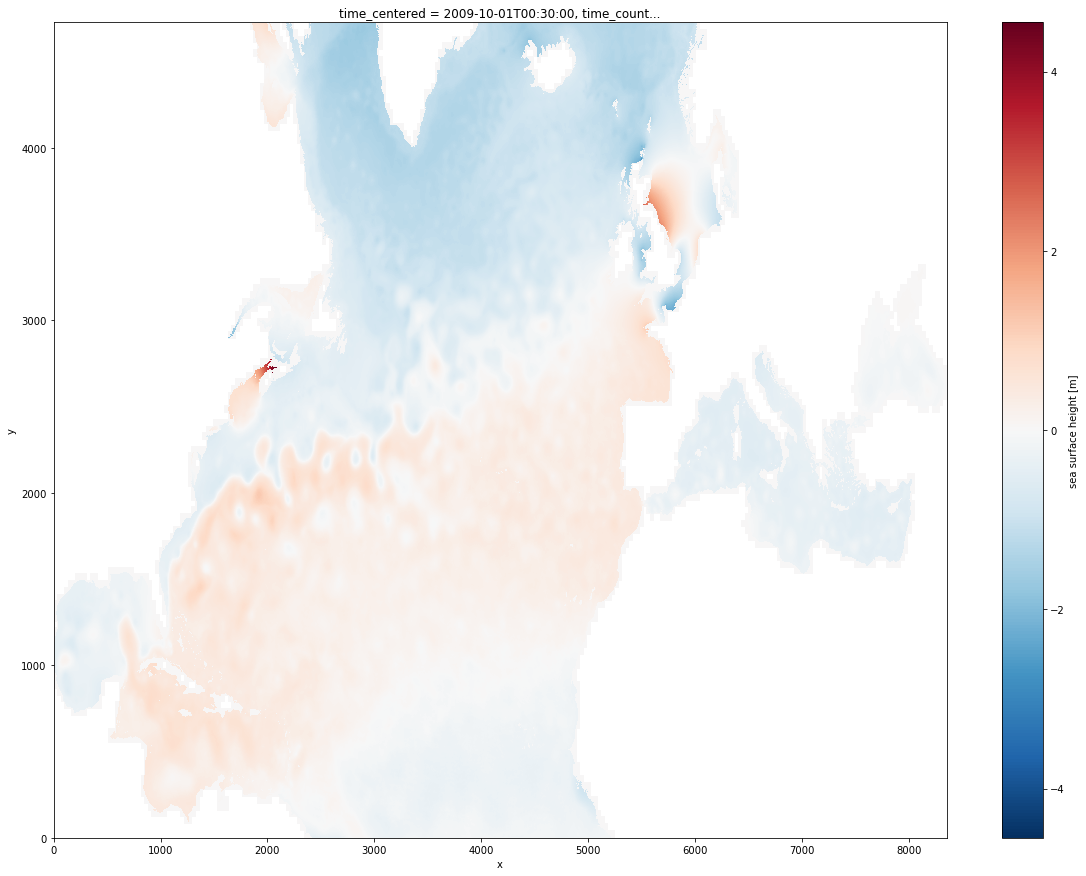

In [15]:
fig=plt.figure(figsize=(20,15))
data.plot()

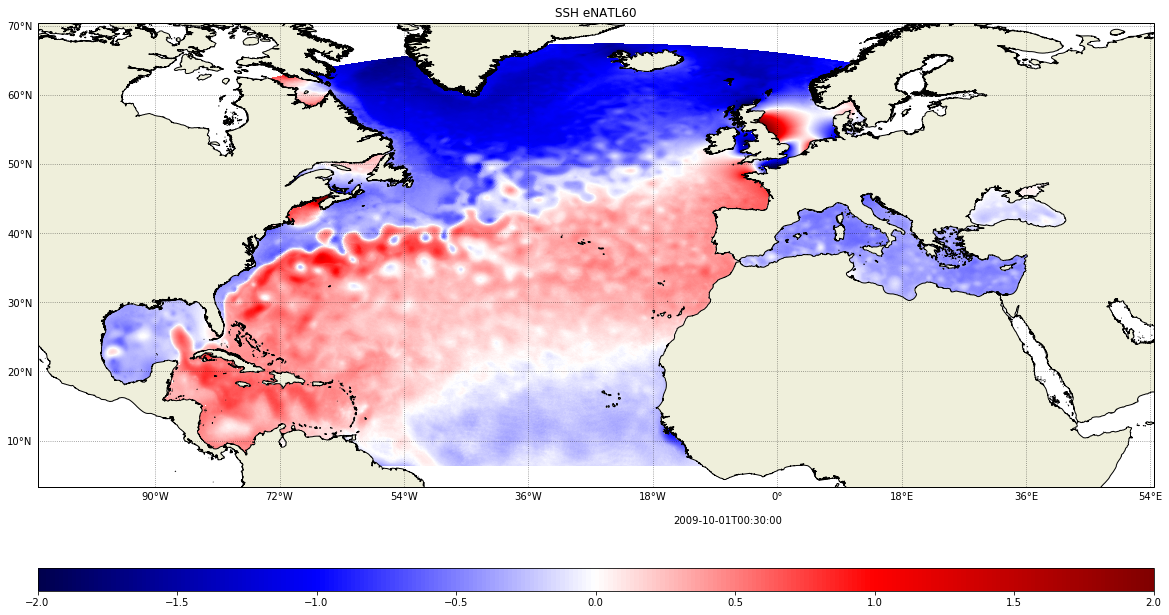

In [17]:
gridfile = '/mnt/alberta/equipes/IGE/meom/workdir/albert/eNATL60/eNATL60-I/coordinates_eNATL60.nc'
dsgrid=xr.open_dataset(gridfile)

date='2009-10-01T00:30:00'
lat=dsgrid.nav_lat.values
lon=dsgrid.nav_lon.values


data=ds.sel(time_counter=date)['sossheig'].values

fig=plt.figure(figsize=(20,15))
plot_surf(111,data[0],lon,lat,-2,2,div_cmap,'SSH eNATL60',date)